In [41]:
!pip install scikit-learn


Defaulting to user installation because normal site-packages is not writeable


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   CustomerID        500 non-null    object
 1   Tenure            500 non-null    int64 
 2   MonthlyCharges    500 non-null    int64 
 3   TotalCharges      500 non-null    int64 
 4   Contract          500 non-null    object
 5   PaymentMethod     500 non-null    object
 6   PaperlessBilling  500 non-null    object
 7   SeniorCitizen     500 non-null    int64 
 8   Churn             500 non-null    int64 
dtypes: int64(5), object(4)
memory usage: 35.3+ KB
None
CustomerID          0
Tenure              0
MonthlyCharges      0
TotalCharges        0
Contract            0
PaymentMethod       0
PaperlessBilling    0
SeniorCitizen       0
Churn               0
dtype: int64


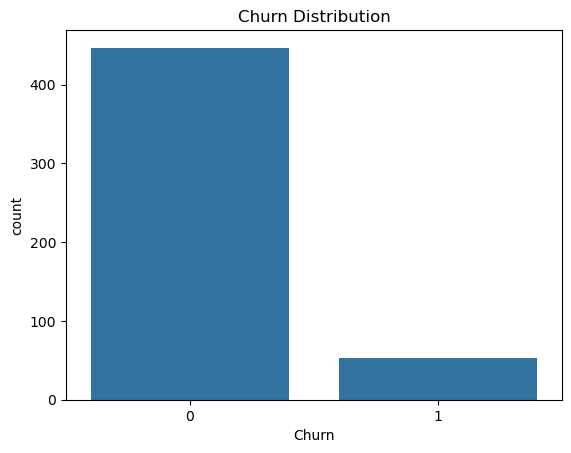

CustomerID          object
Tenure               int64
MonthlyCharges       int64
TotalCharges         int64
Contract            object
PaymentMethod       object
PaperlessBilling    object
SeniorCitizen        int64
Churn                int64
dtype: object

Missing Values:
 CustomerID          0
Tenure              0
MonthlyCharges      0
TotalCharges        0
Contract            0
PaymentMethod       0
PaperlessBilling    0
SeniorCitizen       0
Churn               0
dtype: int64


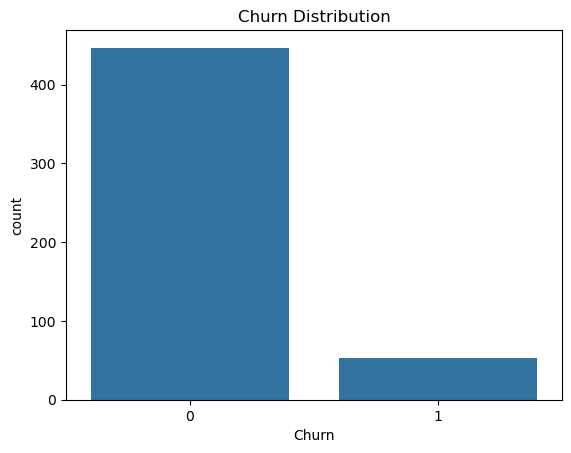

   Tenure_mm  MonthlyCharges_mm  TotalCharges_mm
0   0.071429           0.245810         0.176305
1   0.285714           0.519553         0.203498
2   0.371429           0.061453         0.165454
3   0.742857           0.050279         0.892506
4   0.214286           0.921788         0.110303
   Tenure_std  MonthlyCharges_std  TotalCharges_std
0   -1.478807           -0.959185         -1.194621
1   -0.752287           -0.012290         -1.100305
2   -0.461679           -1.596890         -1.232259
3    0.797622           -1.635539          1.289485
4   -0.994460            1.379066         -1.423548
Top correlated features:
 Churn                    1.000000
Tenure                   0.509208
Tenure_std               0.509208
Tenure_mm                0.509208
IsLongTerm               0.504270
AvgMonthlySpend          0.471932
CustomerLifetimeValue    0.367997
Contract_One year        0.157484
CustomerID_C00397        0.130007
CustomerID_C00390        0.130007
Name: Churn, dtype: float64


In [50]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from scipy import stats
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


# -------------------------------
# Day 1: Load & Explore
# -------------------------------
df = pd.read_csv("C:/Users/Dell/Downloads/customer_churn (3).csv")

df.columns = df.columns.str.strip()

# Convert TotalCharges safely
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

print(df.info())
print(df.isnull().sum())

sns.countplot(x='Churn', data=df)
plt.title("Churn Distribution")
plt.show()


# Data types & missing values
print(df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())

# Churn distribution
sns.countplot(x='Churn', data=df)
plt.title("Churn Distribution")
plt.show()


# -------------------------------
# Day 2: Encoding (3 methods)
# -------------------------------
le = LabelEncoder()

# Encode target
df['Churn'] = le.fit_transform(df['Churn'])

# Binary encoding
binary_cols = [col for col in df.columns if df[col].dtype == 'object' and df[col].nunique() == 2]
for col in binary_cols:
    df[col] = le.fit_transform(df[col])

# One-hot encoding
df = pd.get_dummies(df, drop_first=True)

# Drop CustomerID (identifier)
if 'customerID' in df.columns:
    df.drop('customerID', axis=1, inplace=True)

# -------------------------------
# Day 3: Feature Scaling
# -------------------------------
scaler_mm = MinMaxScaler()
scaler_std = StandardScaler()

scale_cols = ['Tenure', 'MonthlyCharges', 'TotalCharges']
df[[c + '_mm' for c in scale_cols]] = scaler_mm.fit_transform(df[scale_cols])
df[[c + '_std' for c in scale_cols]] = scaler_std.fit_transform(df[scale_cols])



print(df.head()[['Tenure_mm','MonthlyCharges_mm','TotalCharges_mm']])
print(df.head()[['Tenure_std','MonthlyCharges_std','TotalCharges_std']])


# -------------------------------
# Day 4: Outlier Detection
# -------------------------------
Q1 = df['MonthlyCharges'].quantile(0.25)
Q3 = df['MonthlyCharges'].quantile(0.75)
IQR = Q3 - Q1
df['MonthlyCharges'] = np.clip(df['MonthlyCharges'],
                               Q1 - 1.5 * IQR,
                               Q3 + 1.5 * IQR)

z_scores = np.abs(stats.zscore(df[['MonthlyCharges', 'TotalCharges']]))
df = df[(z_scores < 3).all(axis=1)]

# -------------------------------
# Day 5: Feature Engineering (5+)
# -------------------------------
df['AvgMonthlySpend'] = df['TotalCharges'] / (df['Tenure'] + 1)
df['CustomerLifetimeValue'] = df['MonthlyCharges'] * df['Tenure']
df['PaymentEfficiency'] = df['TotalCharges'] / (df['MonthlyCharges'] + 1)
df['IsLongTerm'] = (df['Tenure'] > 24).astype(int)
df['HighSpender'] = (df['MonthlyCharges'] > df['MonthlyCharges'].median()).astype(int)

df.replace([np.inf, -np.inf], 0, inplace=True)

# -------------------------------
# Day 6: Feature Selection
# -------------------------------
corr = df.corr()['Churn'].abs().sort_values(ascending=False)
print("Top correlated features:\n", corr.head(10))

X = df.drop('Churn', axis=1)
y = df['Churn']

rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=X.columns)
print("Top 10 Important Features:\n", importances.sort_values(ascending=False).head(10))

# -------------------------------
# Day 7: Model Building
# -------------------------------

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Scale all features + logistic regression
model_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(
        solver='liblinear',
        max_iter=3000,
        random_state=42
    ))
])

model_pipeline.fit(X_train, y_train)

y_pred = model_pipeline.predict(X_test)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))
